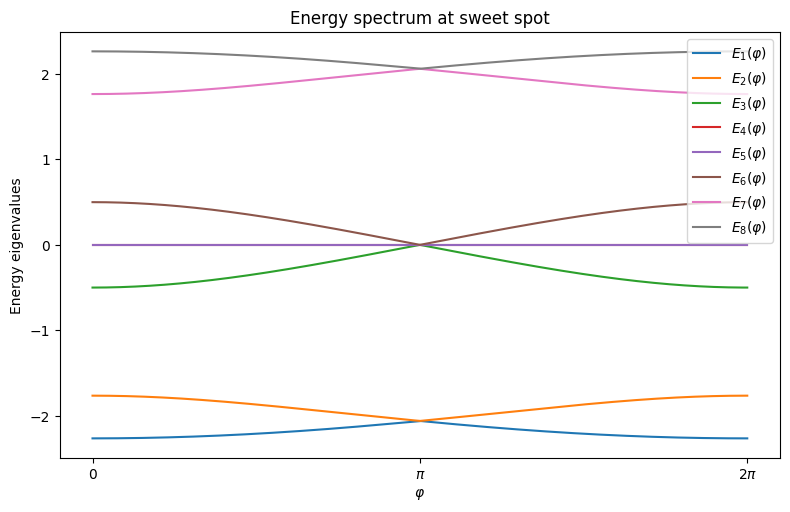

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown

def hamiltonian(eps, t, Delta, t_c):
        epsilon1, epsilon2, epsilon3, epsilon4 = eps
        t_L = t[0]
        t_R = t[1]
        Delta_L = Delta[0]
        Delta_R = Delta[1]

        # Compute complex conjugates
        t_L_star = np.conjugate(t_L)
        t_R_star = np.conjugate(t_R)
        Delta_L_star = np.conjugate(Delta_L)
        Delta_R_star = np.conjugate(Delta_R)

        M = np.array([
            [epsilon1,      t_L,        0,           0,            0,            Delta_L,      0,             0       ],
            [t_L_star,      epsilon2,   t_c,         0,           -Delta_L, 0,            0,             0       ],
            [0,             t_c,        epsilon3,    t_R,          0,             0,            0,             Delta_R],
            [0,             0,          t_R_star,    epsilon4,     0,             0,           -Delta_R,  0      ],
            [0,            -Delta_L_star, 0,         0,         -epsilon1,     -t_L_star,      0,             0       ],
            [Delta_L_star,       0,          0,           0,          -t_L,         -epsilon2,     -t_c,           0       ],
            [0,             0,          0,          -Delta_R_star, 0,           -t_c,         -epsilon3,     -t_R_star],
            [0,             0,          Delta_R_star,     0,            0,            0,           -t_R,         -epsilon4 ]
        ])
        return M

def compute_eigensystem(epsilon1, epsilon2, t, Delta):
    H = hamiltonian(epsilon1, epsilon2, t, Delta)
    eigvals, eigvecs = np.linalg.eig(H)
    idx = np.argsort(eigvals)  # Sort eigenvalues and vectors
    return np.real(eigvals[idx]), np.real(eigvecs[:, idx])

num_sites = 4  # total number of sites/qubits
# Define parameters

# Numerical values for on-site energies and tunneling
eps = np.zeros(num_sites)  # ε_i = 1 for all sites
tc  = 0.5                # central coupling strength

# Sweep phi from 0 to 6π
phi_list = np.linspace(0, 2*np.pi, 1000)
# Array to store the two lowest eigenvalues
n = 8
levels = np.zeros((len(phi_list), n))

# Loop over phi values, bind parameters, diagonalize, and store lowest two levels
for i, phi in enumerate(phi_list):
    # pairing phases
    delta0 = np.exp(-1j * phi / 2)
    delta1 = np.exp(+1j * phi / 2)
    t0 = delta0
    t1 = delta1

    # get numeric Hamiltonian and eigenvalues
    eigs, eigs_vec = compute_eigensystem(eps, [t0, t1], [delta0, delta1], tc)     
    # save two lowest levels
    # select the 4 eigenvalues nearest to zero (smallest |E|)

    selected = np.argsort(np.abs(eigs))[:4]
    # sort these so plotting is ordered from lowest to highest
    levels[i, :] = eigs#eigs[5:11]#eigs[selected]

# Plot the selected energy levels vs varphi
plt.figure(figsize=(8,5))
for j in range(n):
    plt.plot(phi_list, levels[:, j], label=fr'$E_{{{j+1}}}(\varphi)$')

# Label x-axis with varphi ticks at multiples of 2π
ticks = [0, np.pi, 2*np.pi]
labels = [r'$0$', r'$\pi$', r'$2\pi$']
plt.xticks(ticks, labels)

plt.xlabel(r'$\varphi$')  # use varphi
plt.ylabel('Energy eigenvalues')
plt.legend()
plt.tight_layout()
plt.title(r'Energy spectrum at sweet spot')
plt.savefig("figures/energy/spectrum02pi_sweet_spot.pdf")
plt.show()




In [10]:
eigs, eigs_vec = compute_eigensystem(eps, [t0, t1], [delta0, delta1], tc)  

eigs

array([-2.26556444e+00, -1.76556444e+00, -5.00000000e-01, -3.18360778e-16,
        1.19290836e-34,  5.00000000e-01,  1.76556444e+00,  2.26556444e+00])